In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import  train_test_split
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
import pickle
import gzip

os.chdir('../')
from functions.model_wrapper import Tree_Model, rfm_params, xgboost_params
from functions.dataprep import group_values, replace_DateTime_CycleTime, strong_low_pass_filter, get_y_w_threshold

# These are batteries that show anomalies in the measnurements, and are therefore excluded.
excl_filenames = ['2018-04-12_batch8_CH46', '2017-06-30_3_6C-30per_6C_CH15', '2017-06-30_2C-7per_5_5C_CH12',
                  '2018-04-12_batch8_CH46', '2017-06-30_6C-60per_3C_CH48']

In [2]:
with gzip.open('data/filtered_data_frames.pckl', 'rb') as f:
    filtered_data_frames = pickle.load(f)

In [3]:
# get y which is number of cycle it dropped below threshold
threshold = 0.9
X_CC =  filtered_data_frames[0]
X_CC = X_CC[[col for col in X_CC.columns if col not in excl_filenames]]

y_all = get_y_w_threshold(X_CC, threshold)

In [4]:
filtered_data_frames[1].iloc[:1000,:]
y_all.isnull().sum()

np.int64(0)

In [5]:
first100rows_data_frames = [data_frame.iloc[: 100, :] for data_frame in filtered_data_frames]
X_all = pd.concat(first100rows_data_frames, axis = 0).T
X_all = X_all.T[[col for col in X_all.T.columns if col not in excl_filenames]].T
X_all.iloc[:,:]

,2_Charge_Capacity,3_Charge_Capacity,4_Charge_Capacity,5_Charge_Capacity,6_Charge_Capacity,7_Charge_Capacity,8_Charge_Capacity,9_Charge_Capacity,10_Charge_Capacity,11_Charge_Capacity,...,94_CycleTime,95_CycleTime,96_CycleTime,97_CycleTime,98_CycleTime,99_CycleTime,100_CycleTime,101_CycleTime,102_CycleTime,schedule_version
2017-06-30_4_4C-55per_6C_CH19,1.0,0.999469,0.999469,0.999469,1.000947,1.000947,1.001048,1.000631,1.000631,1.000275,...,60.100992,60.08787,60.08787,60.073277,60.073277,60.051363,59.927752,59.927752,59.927752,7.00.08
2018-04-12_batch8_CH38,1.0,1.000355,1.000355,1.000355,1.000875,1.000858,1.000857,1.000757,1.000705,1.000661,...,44.621987,44.572147,44.572147,44.517665,44.467317,44.467317,44.443833,44.443833,44.453385,7.00.13
2018-04-12_batch8_CH10,1.0,1.000607,1.000607,1.000607,1.000607,1.000607,1.000607,1.000607,1.000607,1.000607,...,45.564103,45.419542,45.419542,45.395157,45.395157,45.395157,45.395157,45.54824,45.54824,7.00.13
2017-05-12_7C-30per_3_6C_CH39,1.0,1.000993,1.000993,1.000993,1.000993,1.000993,1.000993,1.001566,1.001566,1.001566,...,51.470997,51.470997,51.470997,51.481427,51.481427,51.481427,51.482802,51.47205,51.47205,7.00.08
2017-06-30_3_6C-80per_3_6C_CH1,1.0,0.999561,0.999561,0.999561,1.000303,0.999825,0.999825,0.999825,0.999735,0.999578,...,50.087073,48.846152,48.811922,48.811922,48.811922,48.811922,49.116543,49.116543,49.383853,7.00.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-12_7C-40per_3_6C_CH41,1.0,1.001021,1.001021,1.001021,1.001021,1.001021,1.001021,1.001021,1.001021,1.001021,...,51.141612,51.14329,51.14329,51.142278,51.142218,51.142218,51.14201,51.14202,51.141435,7.00.08
2018-04-12_batch8_CH21,1.0,1.000793,1.000793,1.000793,1.000793,1.000793,1.000793,1.000793,1.000793,1.002509,...,47.211137,47.25177,47.25177,47.25177,47.225552,47.225552,47.211918,47.211918,47.211918,7.00.13
2018-04-12_batch8_CH35,1.0,1.000817,1.000817,1.000817,1.000817,1.000817,1.000817,1.000817,1.000817,1.003206,...,46.469207,46.481423,46.433762,46.388213,46.388213,46.388213,46.24005,46.24005,46.24005,7.00.13
2017-06-30_4_8C-80per_4_8C_CH8,1.0,1.002038,1.002038,1.003054,1.003054,1.003054,1.003788,1.003788,1.003788,1.004396,...,59.772307,59.879507,59.86149,59.810603,59.786073,59.786073,59.786073,59.786073,59.786073,7.00.08


In [6]:
X_all.fillna(0, inplace = True)

In [7]:
with gzip.open('data/CC_data_frames_FFT.pckl', 'rb') as f:
    CC_data_frames_FFT = pickle.load(f)
df_FF_peaks = pd.concat(CC_data_frames_FFT)
X_all = pd.merge(X_all, df_FF_peaks, left_index=True, right_index=True)

In [8]:
with gzip.open('data/CV_data_frames_FFT.pckl', 'rb') as f:
    CV_data_frames_FFT = pickle.load(f)
df_FF_peaks = pd.concat(CV_data_frames_FFT)

X_all = pd.merge(X_all, df_FF_peaks, left_index=True, right_index=True)

In [9]:
X_all["schedule_version"] = X_all["schedule_version"] == '7.00.08'

In [10]:
X_all = X_all.astype('float')
X_all['schedule_version'] = X_all['schedule_version'].astype('bool')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    train_size=0.8, test_size=0.2, 
                                                    random_state=120)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    train_size=0.9, test_size=0.1, 
                                                    random_state=
                                                  120)
xgboost_params['eval_set'] = [(X_train, y_train), (X_val, y_val)]

In [86]:
xgboost_params["n_jobs"] = 7
xgboost_params['n_estimators'] = 100_000_000
xgboost_params['learning_rate'] = 1e-5
xgboost_params["max_depth"]= 6
xgboost_params["verbose"] = 1000
xgboost_params["early_stopping_rounds"] = 1000

[21:08:27] ======== Monitor (0): HostSketchContainer ========
[21:08:27] AllReduce: 0.000229s, 1 calls @ 229us

[21:08:27] MakeCuts: 0.001508s, 1 calls @ 1508us

[21:08:27] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70448	validation_1-rmse:219.00752


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-e_IOXrlx-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:08:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	validation_0-rmse:329.10918	validation_1-rmse:217.19325
[2000]	validation_0-rmse:326.54172	validation_1-rmse:215.38846
[3000]	validation_0-rmse:323.99227	validation_1-rmse:213.61933
[4000]	validation_0-rmse:321.46669	validation_1-rmse:211.86309
[5000]	validation_0-rmse:318.95740	validation_1-rmse:210.10941
[6000]	validation_0-rmse:316.47721	validation_1-rmse:208.39547
[7000]	validation_0-rmse:314.01086	validation_1-rmse:206.68939
[8000]	validation_0-rmse:311.57039	validation_1-rmse:205.03239
[9000]	validation_0-rmse:309.14885	validation_1-rmse:203.35934
[10000]	validation_0-rmse:306.74855	validation_1-rmse:201.73650
[11000]	validation_0-rmse:304.37209	validation_1-rmse:200.12751
[12000]	validation_0-rmse:302.00887	validation_1-rmse:198.51602
[13000]	validation_0-rmse:299.67121	validation_1-rmse:196.94726
[14000]	validation_0-rmse:297.34556	validation_1-rmse:195.35967
[15000]	validation_0-rmse:295.04815	validation_1-rmse:193.81346
[16000]	validation_0-rmse:292.76613	validation_1-

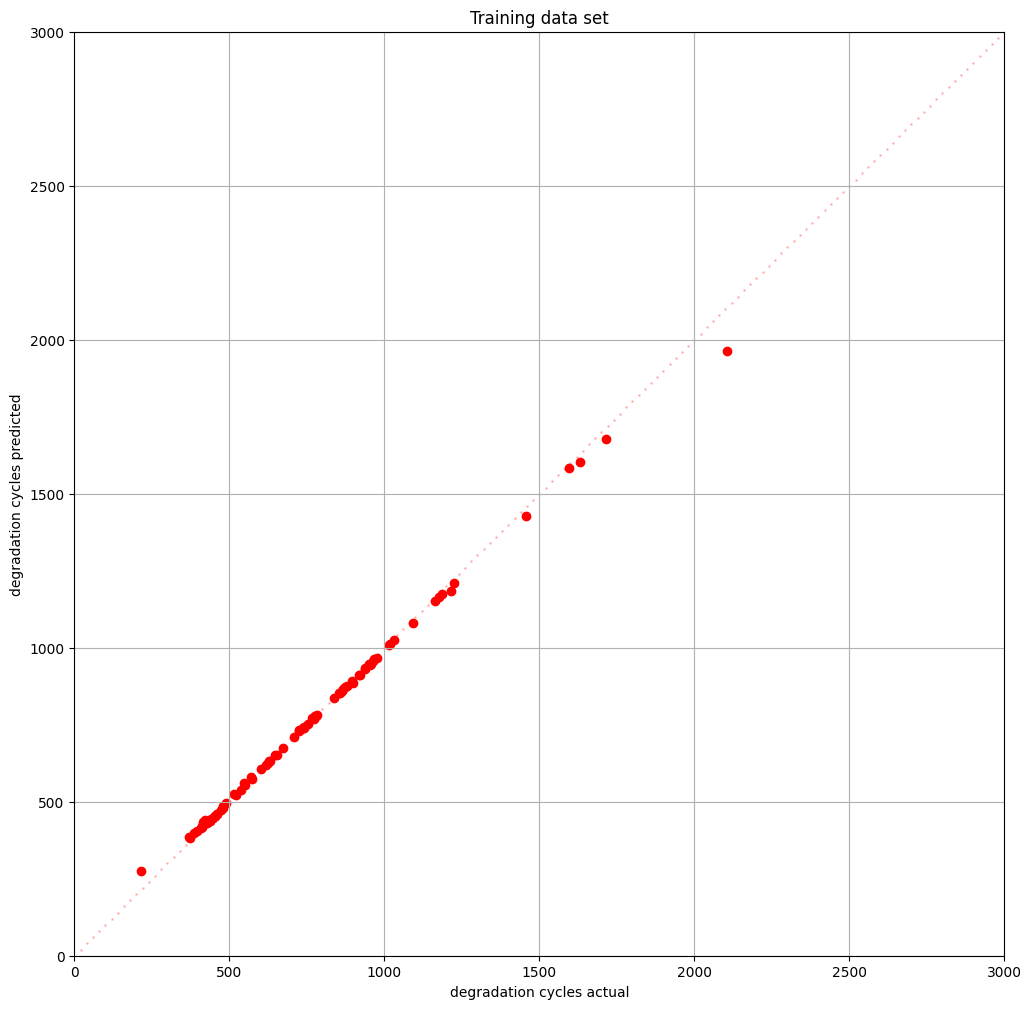

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.5, colsample_bytree=0.5,
             device=None, early_stopping_rounds=1000, enable_categorical=False,
             eval_metric='rmse',
             eval_set=[(                               2_Charge_Capacity  3_Charge_Capacity  \
2017-05-12_5_4C-50per_3C_CH14                1.0           1.001425   
2017-05-12_7C-40per_3C_CH38                  1.0           1.000948   
2018-04-12_batch8_CH4...
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=1e-05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=100000000, n_jobs=7, num_parallel_tree=None, ...)

In [106]:
#Depth = 6
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)

MdAPE is 12.425810715247845%
R2: 0.752, RMSE: 161.486, MAE: 119.883
Plotting scatter plot..


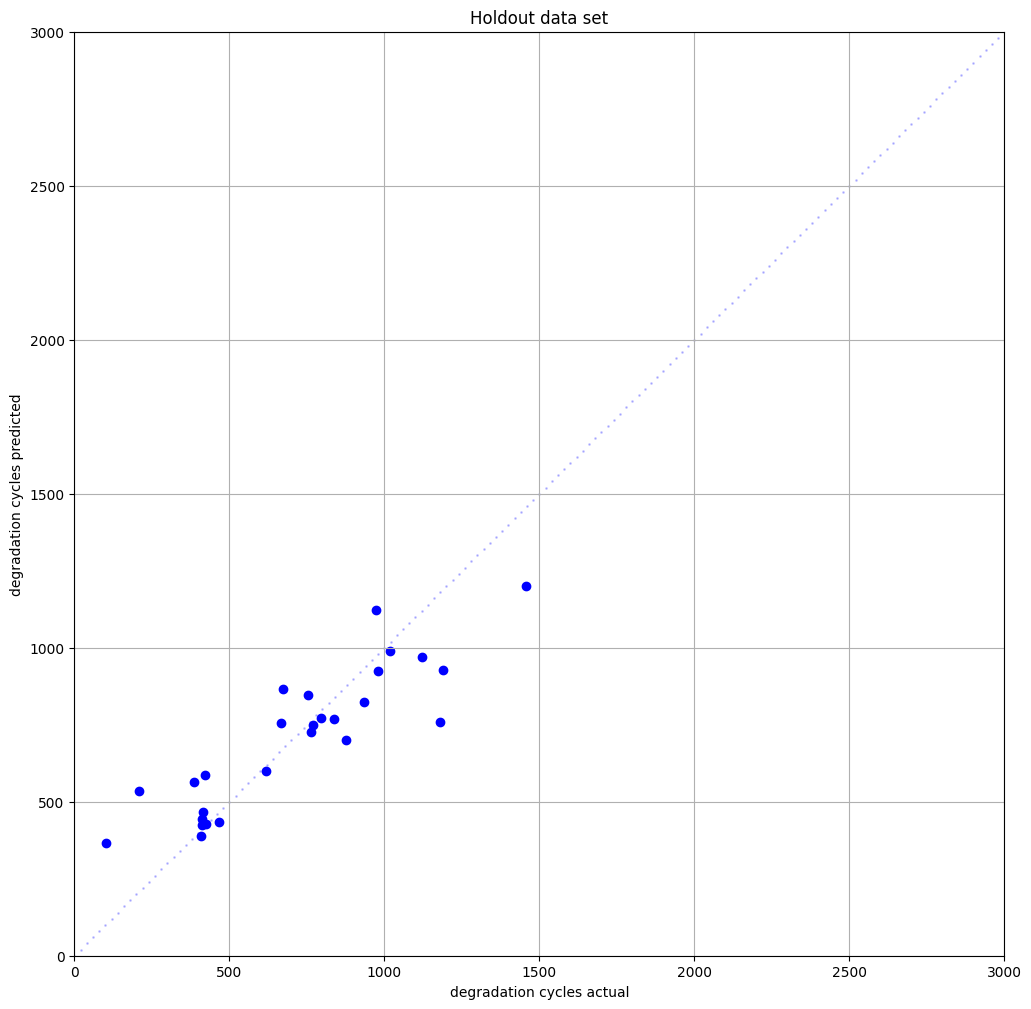

array([ 443.21686,  536.0774 , 1123.7408 ,  757.7045 ,  772.92413,
        427.81033,  847.6906 ,  865.14246,  365.22943,  564.0924 ,
        748.7247 ,  423.15985,  970.2766 ,  599.1151 ,  433.80246,
       1199.1908 ,  925.89374,  700.8734 ,  387.63986,  725.38385,
        467.78488,  990.4349 ,  585.9144 ,  928.8926 ,  768.6493 ,
        822.1902 ,  754.6778 ], dtype=float32)

In [107]:
gbm.predict(X_test, y_test)

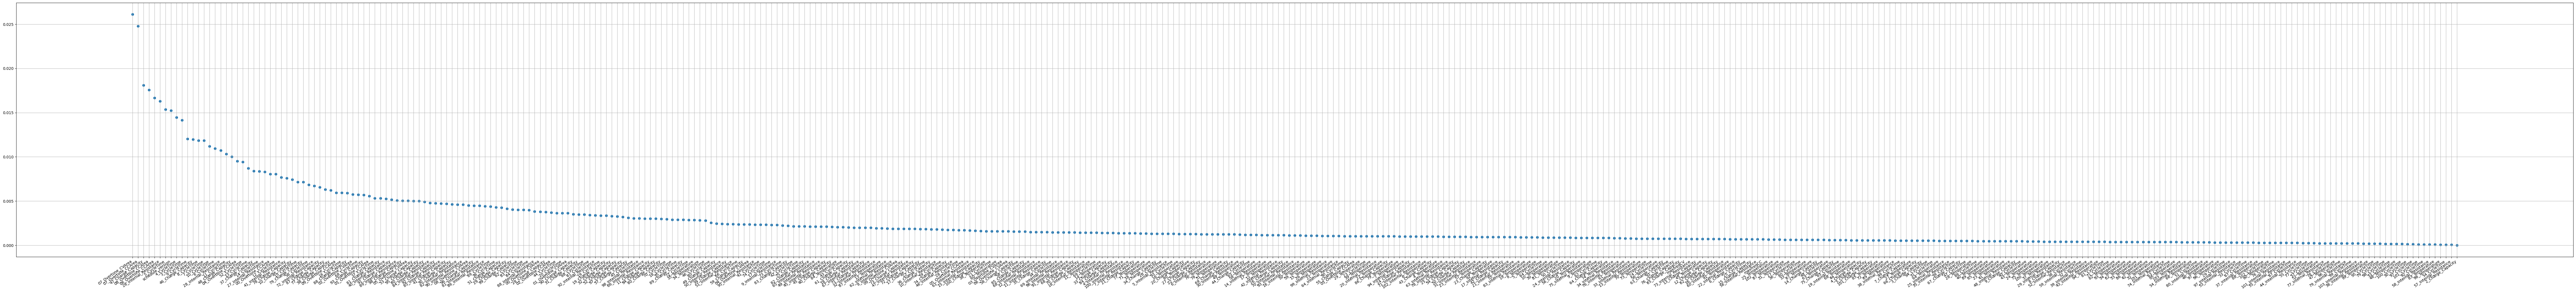

In [108]:
data_points =[x[0] for x in gbm.feature_imp]
importances =[x[1] for x in gbm.feature_imp]
plt.figure(figsize=(120,12))
plt.scatter(data_points, importances)
plt.xticks(rotation = 35, horizontalalignment = 'right')
plt.grid()
plt.savefig('figures/feature_imp.png')
plt.show()


In [109]:
 [(x[0], float(x[1])) for x in gbm.feature_imp]

[('07_Overtone_CVArea', 0.02612653560936451),
 ('07_Overtone_CCArea', 0.024789217859506607),
 ('47_Charge_Capacity', 0.018102914094924927),
 ('08_Overtone_CCArea', 0.017570072785019875),
 ('06_Overtone_CCArea', 0.01666710339486599),
 ('26_Internal_Resistance', 0.01631263643503189),
 ('5_CycleTime', 0.01537744328379631),
 ('schedule_version', 0.015225430950522423),
 ('4_CycleTime', 0.014473951421678066),
 ('3_CycleTime', 0.014141024090349674),
 ('9_CycleTime', 0.012029286473989487),
 ('46_Charge_Capacity', 0.011975418776273727),
 ('8_CycleTime', 0.011863652616739273),
 ('7_CycleTime', 0.011836079880595207),
 ('10_CycleTime', 0.011203592643141747),
 ('6_CycleTime', 0.01095679309219122),
 ('28_Internal_Resistance', 0.0107413986697793),
 ('11_CycleTime', 0.010333036072552204),
 ('48_Charge_Capacity', 0.01001252606511116),
 ('04_Overtone_CCArea', 0.009509737603366375),
 ('52_CycleTime', 0.009430558420717716),
 ('13_CycleTime', 0.008698660880327225),
 ('37_Charge_Capacity', 0.008392749354243

In [110]:
importances_sums = {}
for feature_imp in gbm.feature_imp:
    category = feature_imp[0].split('_')[-1]
    if category in importances_sums.keys():
        importances_sums[category] += float(feature_imp[1])
    else:
        importances_sums[category] = float(feature_imp[1])
import_sums = [(key, importances_sums[key]) for key in importances_sums.keys()]

import_sums = sorted(import_sums, key=lambda x: x[1], reverse = True)
str([(x[0], float(np.round(x[1], 5))) for x in import_sums])

"[('CycleTime', 0.28845), ('Capacity', 0.27708), ('Resistance', 0.18778), ('CCArea', 0.09451), ('Temperature', 0.0793), ('CVArea', 0.05626), ('version', 0.01523), ('maxfreqCV', 0.00073), ('maxfreqCC', 0.00067)]"

In [111]:
gbm_model = gbm.model
gbm_model.n_estimators

100000000

In [112]:
errors = gbm_model.evals_result_

In [113]:
errors["validation_1"]['rmse'][-40:]

[88.79134290824477,
 88.79133825267292,
 88.79134827269746,
 88.79134477467207,
 88.79134528631626,
 88.79136892935239,
 88.79136556656196,
 88.79138160181796,
 88.79137551676942,
 88.79137077917999,
 88.79136803763684,
 88.7913695176454,
 88.79137554215633,
 88.7914004994452,
 88.79141213641343,
 88.79142025778214,
 88.79142987941836,
 88.79141730118415,
 88.79138682102587,
 88.79142716277575,
 88.79143188815694,
 88.79143066153021,
 88.79143361397797,
 88.79142912635498,
 88.79141441903805,
 88.79139281258145,
 88.79140594347261,
 88.79145286627838,
 88.79142819973306,
 88.79146495410116,
 88.79145336229924,
 88.79146700091927,
 88.79146294267818,
 88.79150648899889,
 88.79151264800215,
 88.79150816038316,
 88.79151367128861,
 88.79149881434954,
 88.791489046258,
 88.79151570834142]

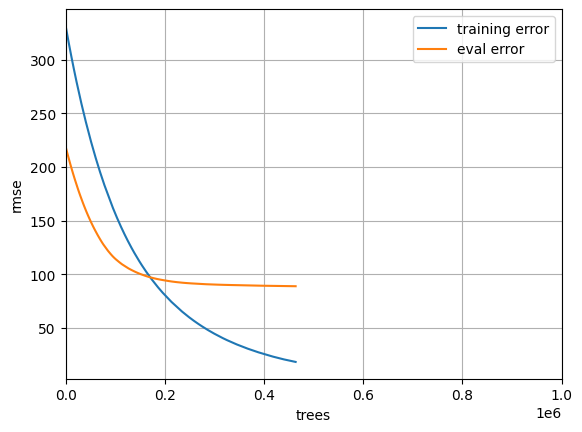

In [114]:
plt.plot(errors['validation_0']['rmse'], label = "training error")
plt.plot(errors['validation_1']['rmse'], label = "eval error")
plt.xlim(0,1e6)
plt.xlabel("trees")
# plt.semilogy(minors = True)
plt.grid()
plt.ylabel("rmse")
plt.legend()
plt.show()

In [115]:
gbm.feature_imp

[('07_Overtone_CVArea', np.float32(0.026126536)),
 ('07_Overtone_CCArea', np.float32(0.024789218)),
 ('47_Charge_Capacity', np.float32(0.018102914)),
 ('08_Overtone_CCArea', np.float32(0.017570073)),
 ('06_Overtone_CCArea', np.float32(0.016667103)),
 ('26_Internal_Resistance', np.float32(0.016312636)),
 ('5_CycleTime', np.float32(0.015377443)),
 ('schedule_version', np.float32(0.015225431)),
 ('4_CycleTime', np.float32(0.014473951)),
 ('3_CycleTime', np.float32(0.014141024)),
 ('9_CycleTime', np.float32(0.0120292865)),
 ('46_Charge_Capacity', np.float32(0.011975419)),
 ('8_CycleTime', np.float32(0.011863653)),
 ('7_CycleTime', np.float32(0.01183608)),
 ('10_CycleTime', np.float32(0.011203593)),
 ('6_CycleTime', np.float32(0.010956793)),
 ('28_Internal_Resistance', np.float32(0.010741399)),
 ('11_CycleTime', np.float32(0.010333036)),
 ('48_Charge_Capacity', np.float32(0.010012526)),
 ('04_Overtone_CCArea', np.float32(0.009509738)),
 ('52_CycleTime', np.float32(0.009430558)),
 ('13_Cycle

In [116]:
category

'Capacity'

In [117]:
importances_sums = {}
for feature_imp in gbm.feature_imp:
    category = feature_imp[0].split('_')[-1]
    if category in importances_sums.keys():
        importances_sums[category] += float(feature_imp[-1])
    else:
        importances_sums[category] = float(feature_imp[-1])

In [118]:
importances_sums

{'CVArea': 0.05625811405479908,
 'CCArea': 0.09451367508154362,
 'Capacity': 0.2770806633052416,
 'Resistance': 0.1877775386456051,
 'CycleTime': 0.28845293554331874,
 'version': 0.015225430950522423,
 'Temperature': 0.07929579065239523,
 'maxfreqCV': 0.0007257565739564598,
 'maxfreqCC': 0.0006700709345750511}

In [119]:
xgboost_params["n_jobs"] = 7
xgboost_params['learning_rate'] = 1e-6
xgboost_params["max_depth"]= 4
xgboost_params["verbose"] = 5000
xgboost_params["early_stopping_rounds"] = 3000


In [ ]:
#Depth = 4
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)

[21:42:52] ======== Monitor (0): HostSketchContainer ========
[21:42:52] AllReduce: 0.000276s, 1 calls @ 276us

[21:42:52] MakeCuts: 0.000453s, 1 calls @ 453us

[21:42:52] DEBUG: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:331.70688	validation_1-rmse:219.00853


/Users/willtong/Library/Caches/pypoetry/virtualenvs/wine-libraries-e_IOXrlx-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[5000]	validation_0-rmse:330.48678	validation_1-rmse:218.10852
[10000]	validation_0-rmse:329.27075	validation_1-rmse:217.20967
[15000]	validation_0-rmse:328.06376	validation_1-rmse:216.30892
[20000]	validation_0-rmse:326.85785	validation_1-rmse:215.40808
[25000]	validation_0-rmse:325.65302	validation_1-rmse:214.51484
[30000]	validation_0-rmse:324.45080	validation_1-rmse:213.61760
[35000]	validation_0-rmse:323.25058	validation_1-rmse:212.72268
[40000]	validation_0-rmse:322.05313	validation_1-rmse:211.82888
[45000]	validation_0-rmse:320.85803	validation_1-rmse:210.93473
[50000]	validation_0-rmse:319.66616	validation_1-rmse:210.04184
[55000]	validation_0-rmse:318.47469	validation_1-rmse:209.15506
[60000]	validation_0-rmse:317.28593	validation_1-rmse:208.26736
[65000]	validation_0-rmse:316.09912	validation_1-rmse:207.37876
[70000]	validation_0-rmse:314.91317	validation_1-rmse:206.48797
[75000]	validation_0-rmse:313.73024	validation_1-rmse:205.60039
[80000]	validation_0-rmse:312.55375	valid

In [ ]:
gbm.predict(X_test, y_test)

In [ ]:
xgboost_params["n_jobs"] = 7
xgboost_params['learning_rate'] = 1e-6
xgboost_params["max_depth"]= 2
xgboost_params["verbose"] = 5000
xgboost_params["early_stopping_rounds"] = 3000


In [ ]:
#Depth = 2
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)

In [ ]:
gbm.predict(X_test, y_test)

In [ ]:
xgboost_params["n_jobs"] = 7
xgboost_params['learning_rate'] = 1e-6
xgboost_params["max_depth"]= 8
xgboost_params["verbose"] = 5000
xgboost_params["early_stopping_rounds"] = 3000

In [ ]:
#Depth = 8
gbm = Tree_Model(Model = XGBRegressor,
                 params = xgboost_params,
                 cycle_max = 3000
                 )
gbm.fit(X_train, y_train)

In [ ]:
gbm.predict(X_test, y_test)

In [ ]:
gbm.predict(X_test, y_test)

In [ ]:
gbm.feature_imp

In [ ]:
X_y = pd.concat([X_all.iloc[:,:], y_all], axis = 1)
X_y

In [ ]:
corr_X_y = X_y.corr()

<Axes: >

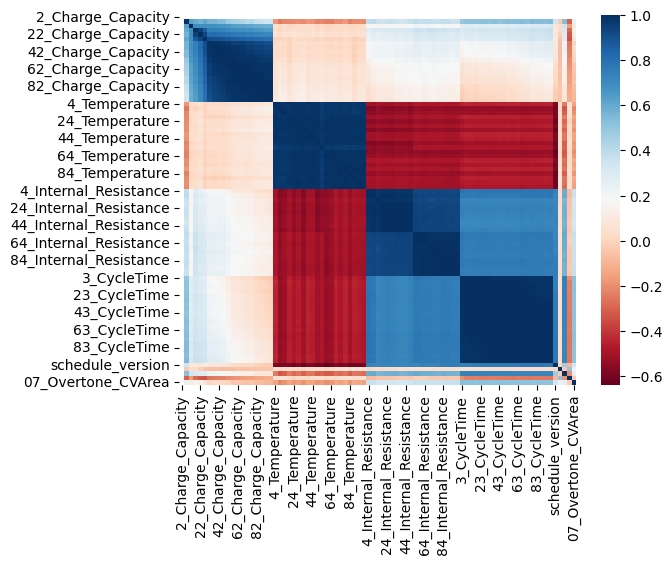

In [105]:
import seaborn as sns
%matplotlib inline

# plot the heatmap
sns.heatmap(corr_X_y.iloc[::5,::5], cmap='RdBu')

In [100]:
corr_X_y.iloc[:,:]

,maxfreqCC,00_Overtone_CCArea,01_Overtone_CCArea,02_Overtone_CCArea,03_Overtone_CCArea,04_Overtone_CCArea,05_Overtone_CCArea,06_Overtone_CCArea,07_Overtone_CCArea,08_Overtone_CCArea,...,01_Overtone_CVArea,02_Overtone_CVArea,03_Overtone_CVArea,04_Overtone_CVArea,05_Overtone_CVArea,06_Overtone_CVArea,07_Overtone_CVArea,08_Overtone_CVArea,09_Overtone_CVArea,0
maxfreqCC,1.000000,0.837642,0.094335,-0.005238,-0.018642,-0.531415,-0.509594,-0.318336,-0.456977,-0.620732,...,-0.037438,0.176808,-0.184924,-0.224648,-0.459696,-0.342371,-0.460980,-0.682788,-0.783171,0.534579
00_Overtone_CCArea,0.837642,1.000000,0.181258,0.161835,0.105432,-0.409155,-0.333777,-0.017778,-0.233621,-0.690117,...,0.069403,0.155340,0.014681,-0.023322,-0.248888,-0.023530,-0.234628,-0.710264,-0.732885,0.403857
01_Overtone_CCArea,0.094335,0.181258,1.000000,0.283104,0.045157,0.162700,0.062652,0.048930,-0.098000,-0.323982,...,0.819386,0.211273,0.055909,0.079034,0.055712,0.091732,-0.093180,-0.336791,-0.275663,0.088179
02_Overtone_CCArea,-0.005238,0.161835,0.283104,1.000000,0.411971,0.330585,0.285104,0.225410,0.215377,-0.076684,...,0.333964,0.652294,0.393020,0.311629,0.255175,0.280721,0.129006,-0.075961,-0.007721,-0.034705
03_Overtone_CCArea,-0.018642,0.105432,0.045157,0.411971,1.000000,0.485111,0.512647,0.288906,0.550907,-0.031878,...,0.155585,0.512836,0.923027,0.809454,0.520876,0.456456,0.232016,-0.046049,0.051523,-0.089630
04_Overtone_CCArea,-0.531415,-0.409155,0.162700,0.330585,0.485111,1.000000,0.770840,0.447725,0.483484,0.282388,...,0.300463,0.286104,0.564438,0.499142,0.759431,0.548717,0.374157,0.270660,0.513033,-0.484107
05_Overtone_CCArea,-0.509594,-0.333777,0.062652,0.285104,0.512647,0.770840,1.000000,0.741269,0.632704,0.319816,...,0.186298,0.275265,0.656742,0.557607,0.880419,0.813303,0.536437,0.369503,0.511952,-0.461597
06_Overtone_CCArea,-0.318336,-0.017778,0.048930,0.225410,0.288906,0.447725,0.741269,1.000000,0.622160,0.090109,...,0.139426,0.101063,0.479999,0.358211,0.767210,0.948329,0.681782,0.210716,0.327076,-0.268412
07_Overtone_CCArea,-0.456977,-0.233621,-0.098000,0.215377,0.550907,0.483484,0.632704,0.622160,1.000000,0.315566,...,0.005264,0.031868,0.672012,0.713223,0.626938,0.654916,0.827299,0.457421,0.378716,-0.385863
08_Overtone_CCArea,-0.620732,-0.690117,-0.323982,-0.076684,-0.031878,0.282388,0.319816,0.090109,0.315566,1.000000,...,-0.269662,-0.199332,0.030263,0.032345,0.201011,0.073691,0.251877,0.921686,0.653945,-0.505744
